# Computational Notebook of "A sensitivity analysis of a regression model of ocean temperature"

## Context




Can data-driven models for weather and climate predictions learn the underlying physics of the system against which they are trained? Or are they simply capable of identifying statistical patterns without any clear link to the underlying physics? In *["A sensitivity analysis of a regression model of ocean temperature"](https://www.cambridge.org/core/journals/environmental-data-science/article/sensitivity-analysis-of-a-regression-model-of-ocean-temperature/089EA5B347F262CEE0B4BDFFBA4E6FF5)*, Furner, R. at al. (2022) run a sensitivity analysis of a regression-based model of ocean temperature, trained against simulations from a 3D ocean model setup, demostrating that regression models are capable of learning much of the physics of the underlying system, such as currents and density.


### Purpose
This notebook aims to complement the science and methodological development embedded within the original paper, using an open infrastructure that allows users to combine interactive code with text and graphical objects, translating research outputs into findable, accessible, interoperable and reusable outputs and code.

### Description
*Describe the main features of the dataset/sensor, preprocessing, modelling or postprocessing routine*


### Highlights

*Provide 3-5 bullet points that convey the use case’s core procedures. Each bullet point must have a maximum of 85 characters, including spaces.*
* Highlight 1
* Highlight 2

### Contributions
*Please indicate key contributions. Notebook authors (mandatory). Optional subheadings, used in published EDS book notebooks, are Dataset originator/creator, Dataset authors, Dataset documentation, Modelling codebase, Modelling publications, Modelling funding and Pipeline documentation. Feel free to add any of them or propose new ones to attribute relevant research contributions.*

#### Notebook
* Author (role), Affiliation, GitHub alias

:::{note}
*Optional: add credits or acknowledgements to data and/or model providers or authors of code snippets*
:::

## Clone the MITgcm GitHub Repo

In [ ]:
!git clone https://github.com/garimamalhotra/repro-challenge-team-3

## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation i.e. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the Python Jupyter notebooks. Don't remove them.*

In [97]:

from IPython.display import (
    Video, Image, HTML, display
)


## Set Project Structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder. Don't remove the lines below.*

In [ ]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Dataset


The training and validation data derive from running the Massachusetts Institute of Technology general circulation model (MITgcm) —a physically based model capable of simulating the ocean or the atmosphere dynamics due to isomorphisms in the governing equations. This research project relies on a simple 2° sector configuration that captures the fundamental dynamics of the ocean, including a realistic overturning circulation. This configuration features a single ocean basin, with:
+ limited topography, 
+ simplified coastlines, and 
+ constant idealized forcing. 

The domain runs from 60°S to 60° N, and is just over 20° wide in longitude. The domain is bounded by land along its northern and southern edges, and a strip of land runs along the eastern/western boundary from 60° N to 40° S.  Below this, in the southernmost 20°, the simulator has a periodic boundary condition, allowing flow that exits to the east and west to return to the domain at the western and eastern boundary. The domain has flat-bottom bathymetry of 5,000 m over most of the domain, with a 2° region of 2,500-m depth at the southernmost 20° of the eastern edge.

The simulator has:

+ 42 depth levels, with the surface layer being the thinnest at 10 m, and the bottom 10 levels being the maximum at 250 m. + 11 cells in the longitudinal direction, and
+ 78 cells in the latitudinal direction.

The simulator has a 12-hr time step, with fields output daily. We focus on daily-mean outputs.


### Download

To download the original dataset, available [here](https://zenodo.org/record/4672260). This dataset is used to train the regression model described in the paper. To download this data locally, run the following line of code. This process will take $\sim 30$ minutes.


In [ ]:
!bash "../infrastructure/downloader.sh"

../infrastructure/downloader.sh: line 6: zenodo_get: command not found
Processing *.gz file...
gzip: *.gz: No such file or directory


### Overview of the Ocean Dynamics

The paper uses a $2°$ sector configuration to simulate ocean dynamics. This configuration features a single ocean basin, with limited topography, simplified coastlines, and constant idealized forcing. This has been used in a number of idealized simulations of Southern Ocean processes and their impacts on the global circulation. This configuration, while relatively simple, captures the fundamental dynamics of the ocean, including a realistic overturning circulation. 



The domain runs from $60° S$ to $60° N$, and is just over $20°$ wide in longitude. The domain is bounded by land along the northern (and southern) edge, and a strip of land runs along the eastern (and western) boundary from $60°$ N to $40° S$ (see Figure 1a). Below this, in the southernmost 20°, the simulator has a periodic boundary condition, allowing flow that exits to the east (west) to return to the domain at the western (eastern) boundary. The domain has flat-bottom bathymetry of 5,000 m over most of the domain, with a 2° region of 2,500-m depth at the southernmost 20° of the eastern edge (i.e., the spit of land forming the eastern boundary continues to the southern boundary as a 2,500-m high subsurface ridge).



 LOADING MITGCM DATASET 


Reading in MITGCM dataset ...
Shape of dataset: (2, 42, 78, 11)


 25 M BELOW THE SURFACE FOR ONE PARTICULAR DAY 


Temperature (°C) at 25 m below the surface for one particular day.


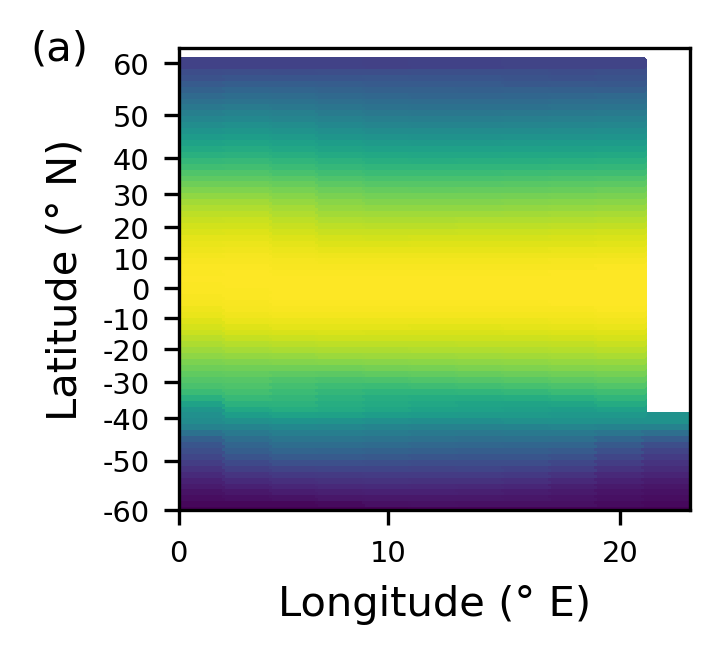

<Figure size 640x480 with 0 Axes>

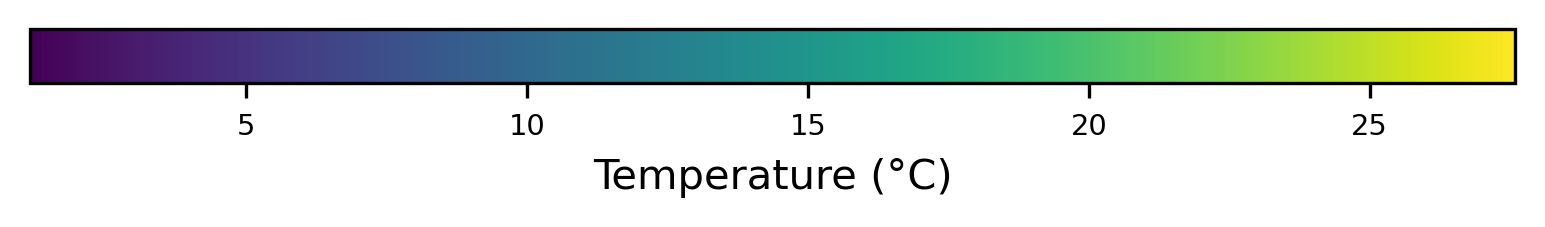

Change in temperature between over 1 day at 25 m below the surface.


<Figure size 640x480 with 0 Axes>

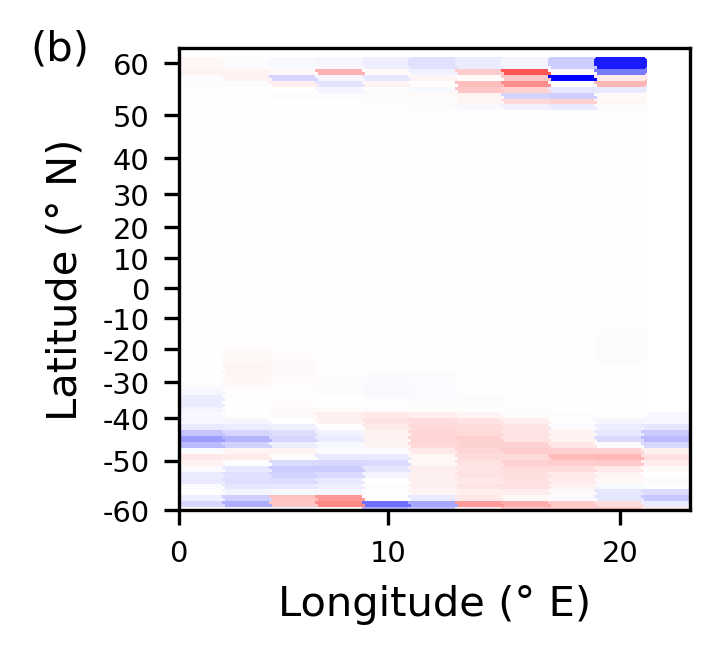

<Figure size 640x480 with 0 Axes>

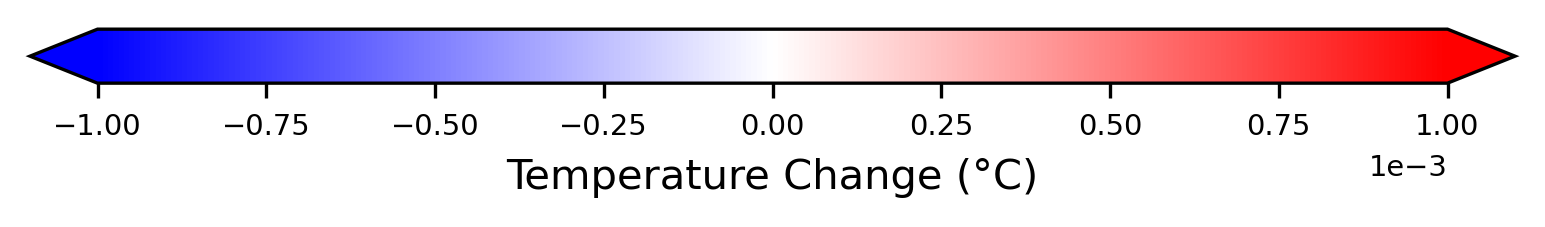

Standard deviation in temperature at 25 m below the surface.


<Figure size 640x480 with 0 Axes>

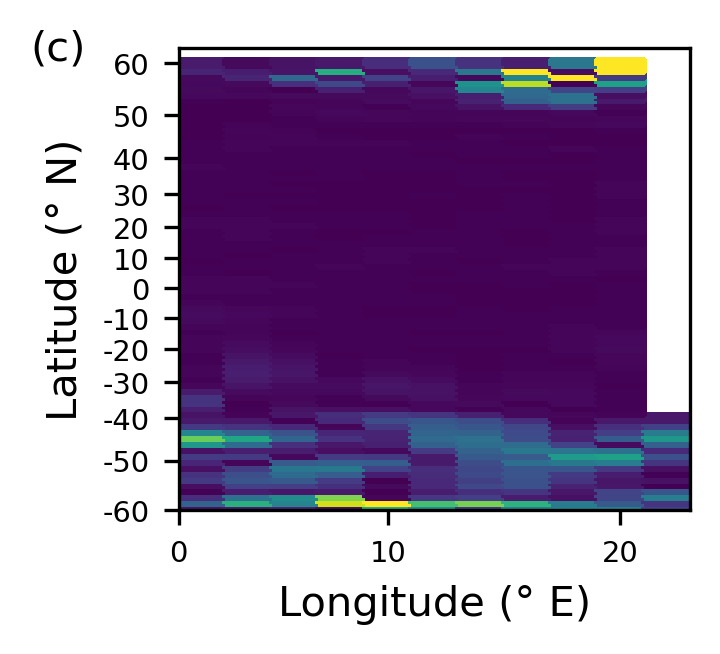

<Figure size 640x480 with 0 Axes>

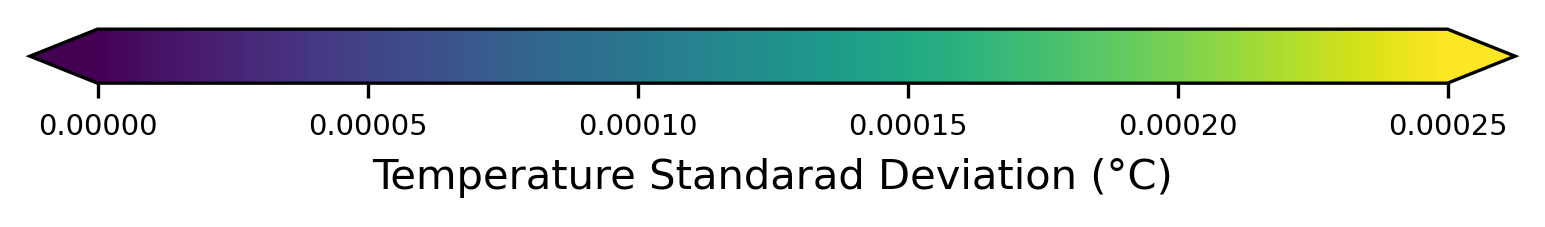


 25 M BELOW THE SURFACE & AT at 13° E FOR ONE PARTICULAR DAY 


Temperature (°C) at 25 m below the surface & at 13° E for one particular day.


<Figure size 640x480 with 0 Axes>

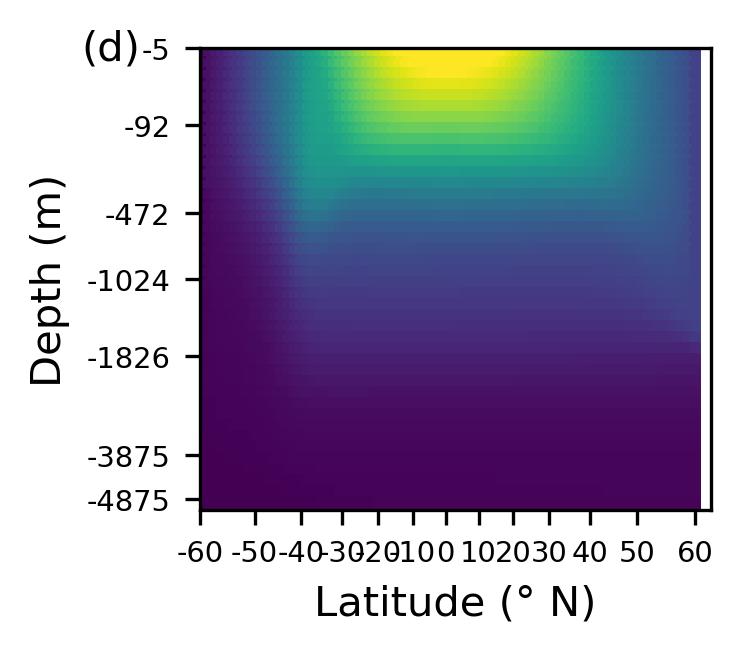

Change in temperature between over 1 day in temperature at 25 m below the surface & at 13° E.


<Figure size 640x480 with 0 Axes>

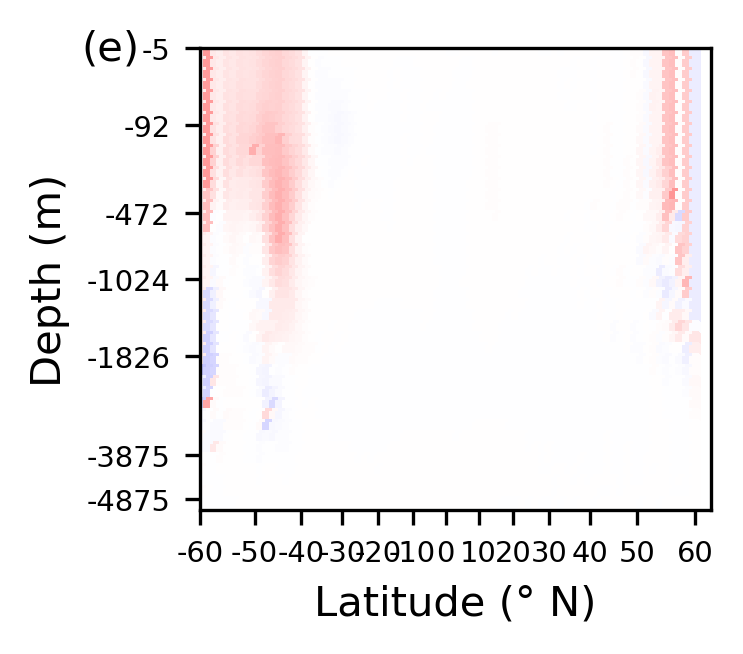

Standard deviation in temperature at 25 m below the surface & at 13° E.


<Figure size 640x480 with 0 Axes>

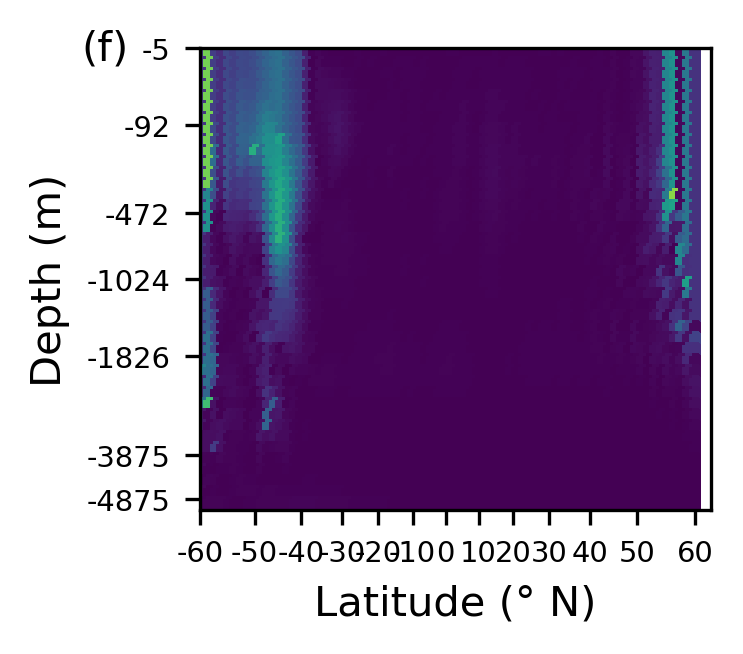

<Figure size 640x480 with 0 Axes>

In [7]:
%run "../src/pipelines/graphs_section.py"

Note that the depth axis is scaled to give each GCM grid cell equal spacing. The simulator shows a realistic temperature distribution with warm surface water near the equator, and cooler water near the poles and in the deep ocean. Temperature changes are largest in the very north of the domain and throughout the southern region. Though changes per day are small, they accumulate over time to give cycles of around 0.2° in some regions of the domain.

## Load Model
*Load full dataset or model from original or mirror sources. If the license of the dataset/model permits, we suggest creating sample data (preprocessed) or model mirror for the notebook stored in a data repository e.g. Zenodo.*

## Visualisation
*Create a visual narrative of the dataset! We suggest exploring libraries suited for interactive plotting e.g. python (Holoviews, Panel, Bokeh).*

## Summary
*Provide 3-5 bullet points summarising the main aspects of the dataset and tools covered in the notebook.*

* Sentence 1 e.g. `tool-name` to perform...
* Sentence 2 e.g. `tool-name` to perform...

## Additional information
**Dataset**: Type here details of dataset(s) version.

**Codebase**: Type here details of codebase version (only for notebooks categorised under modelling/preprocesing/post-processing themes).

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [ ]:
from datetime import date
print(f'Last tested: {date.today()}')